# Final Project
###### Karina Ruban

##### **README** important to filter

##### Added "flag"-values in data:

|df|col|(value)|
|------|------|------|
|Calls |Contact_ID    |0000000000000000000    |
|Calls |Call_Duration_Sec     |0     |
|Deals |Initial_Amount_Paid     |1000000    |
|Deals |Offer_Total_Amount     |1000000     |

## Task 3. Time series analysis:
##### 1. Analyze the trend of creating deals over time and their relationship to calls.
##### 2. Study the distribution of closing time and duration from creation to closing.

## Task 4. Analysis of campaign effectiveness:
##### 1. Compare the efficiency of different campaigns in terms of leads generation and conversion rate.
##### 2. Evaluate the effectiveness of various marketing sources (Source) in generating quality leads.

## Task 5. Analysis of sales department performance:
##### 1. Evaluate the effectiveness of individual deal owners and advertising campaigns in terms of number of deals processed, conversion rate and total sales.

## Task 6. Analysis of payments and products:
##### 1. Study the distribution of payment types and their impact on the success of deals.
##### 2. Analyze the popularity and success of different products and types of education.

## Task 7. Geographic analysis:
##### 1. Analyse the geographical distribution of transactions by city.
##### 2. Study the impact of your knowledge of German on the success of transactions in different cities.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
with open('cleaned_project_data.pickle', 'rb') as f:
    calls, contacts, deals, spend = pickle.load(f)

## Time series analysis

##### Summary:

- ###### Maximum number of transactions: April 2024
- ###### Maximum number of successful transactions: Janury 2024 
- ###### The number of deals increases until April 2024 and then decreases
- ###### The number of successful deals also decreases after reaching a peak in January 2024
- ###### Average number of calls per deal decreased

##### fewer calls to the deal may indicate less need for calls to close the deal -- better lides, improved brand recognition, other channels of communication with the customer, improved scripts for managers. 
##### reducing the number of calls does not reduce the number of successful transactions --> no increase in calls is required

##### Summary:

- ###### The maximum number of deals with a closing date is in 2 quarter 2024
- ###### There is a periodic increase and decrease in the number of closed transactions, which may indicate seasonality or some influence of other factors
- ###### Median closing time -- 5 days

##### Abnormally large closing times require separate research
##### It is necessary to search for the factors that create "seasonality"
##### Reduce SLA to shorten the closing time of the deals and retain the customer

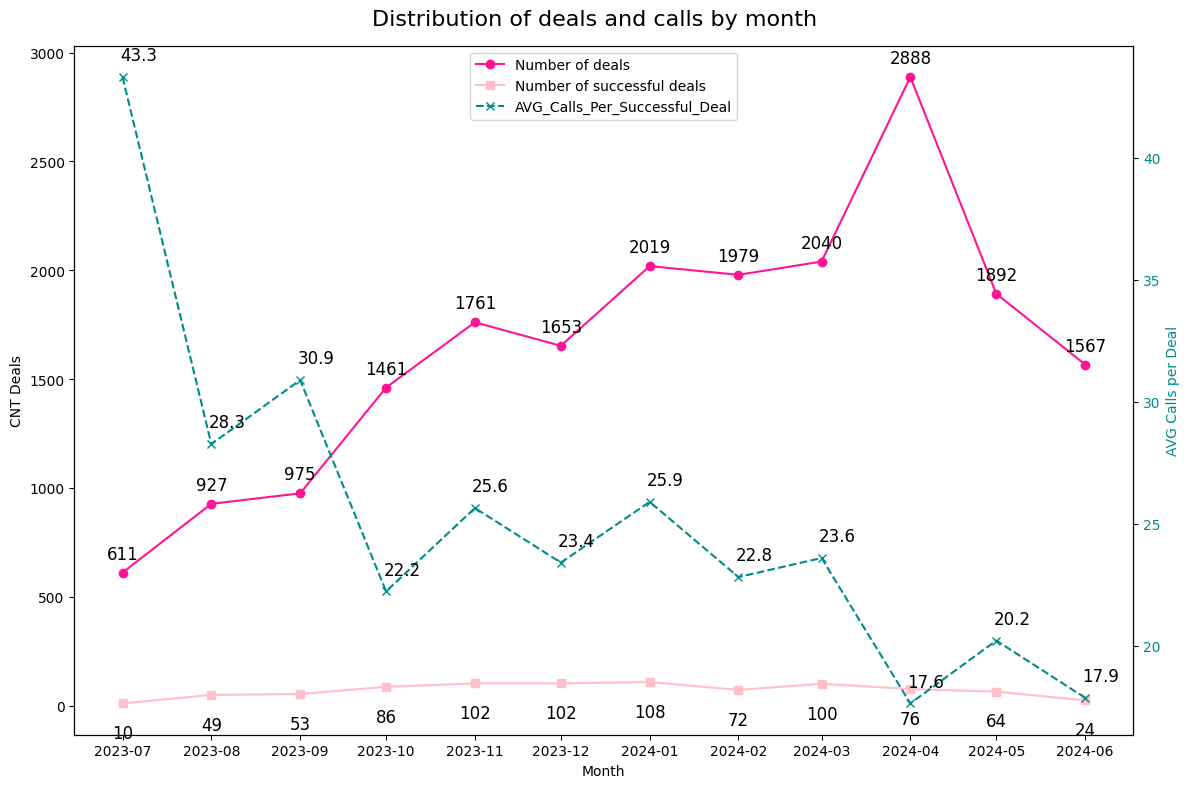

In [3]:
# Analyze the trend of deals over time and their relationship to calls.

# Group and count the number of calls for each contact

call_counts = calls.groupby('Contact_ID').size().reset_index(name='Calls_CNT')

# merge of df to analyze & fill missing values with 0

deals_calls = pd.merge(deals, call_counts, left_on = 'Contact_Name', right_on='Contact_ID', how='left')
deals_calls['Calls_CNT'] = deals_calls['Calls_CNT'].fillna(0).astype(int)

# deals_calls.info()

# aggregation of data by months.

deals_calls_per_month = deals_calls.groupby(deals_calls['Created_Time'].dt.to_period('M')).agg(Deals_CNT=('Deals_ID', 'size'), AVG_Calls_Per_Deal=('Calls_CNT', 'mean')).reset_index()

# set successful deals & aggregation of data by months.

deals_successful = deals_calls[deals_calls['Stage'] == 'Payment Done']
successful_deals_per_month = deals_successful.groupby(deals_successful['Created_Time'].dt.to_period('M')).agg(Successful_Deals_CNT=('Deals_ID', 'size'), AVG_Calls_Per_Successful_Deal=('Calls_CNT', 'mean')).reset_index()

# merge of df to analyze & fill missing values with 0

deals_calls_per_month = pd.merge(deals_calls_per_month, successful_deals_per_month, on='Created_Time', how='left')
deals_calls_per_month['Successful_Deals_CNT'] = deals_calls_per_month['Successful_Deals_CNT'].fillna(0).astype(int)

deals_calls_per_month = deals_calls_per_month.rename(columns={'Created_Time': 'Month'})
deals_calls_per_month['Month'] = deals_calls_per_month['Month'].dt.to_timestamp()
deals_calls_per_month.sort_values('Month', inplace=True)

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.set_xlabel('Month')
ax1.set_ylabel('CNT Deals', color='black')
line1 = ax1.plot(deals_calls_per_month['Month'], deals_calls_per_month['Deals_CNT'], color='deeppink', marker='o', label='Number of deals')
line2 = ax1.plot(deals_calls_per_month['Month'], deals_calls_per_month['Successful_Deals_CNT'], color='pink', marker='s', linestyle='-', label='Number of successful deals')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.set_ylabel('AVG Calls per Deal', color='darkcyan')
line3 = ax2.plot(deals_calls_per_month['Month'], deals_calls_per_month['AVG_Calls_Per_Successful_Deal'], color='darkcyan', marker='x', linestyle='--', label='AVG_Calls_Per_Successful_Deal')
ax2.tick_params(axis='y', labelcolor='darkcyan')

for month, count in zip(deals_calls_per_month['Month'], deals_calls_per_month['Deals_CNT']):
    ax1.annotate(f'{count}', (month, count), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='black')

for month, count in zip(deals_calls_per_month['Month'], deals_calls_per_month['Successful_Deals_CNT']):
    ax1.annotate(f'{count}', (month, count), textcoords="offset points", xytext=(0,-25), ha='center', fontsize=12, color='black')

for month, count in zip(deals_calls_per_month['Month'], deals_calls_per_month['AVG_Calls_Per_Successful_Deal']):
    ax2.annotate(f'{count:.1f}', (month, count), textcoords="offset points", xytext=(-2,12), ha='left', fontsize=12, color='black')

    
fig.suptitle('Distribution of deals and calls by month', fontsize=16)
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper center')
plt.xticks(deals_calls_per_month['Month'], deals_calls_per_month['Month'].dt.strftime('%Y-%m'), ha='right', fontsize=12)
plt.tight_layout()
plt.savefig('Analysis_of_Deals_Calls_Month.png')
plt.show()

max time to close: 334
min time to close: 0
avg time to close: 18.610773970684342
mode time to close: 0    0
Name: Time_To_Close_Days, dtype: int64
median time to close: 5.0


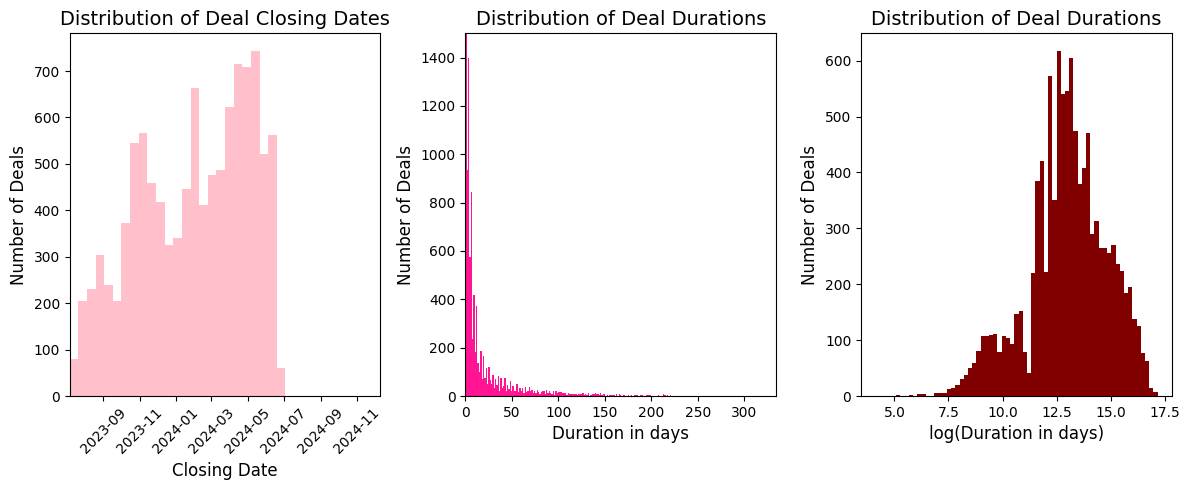

In [4]:
# Изучите распределение времени закрытия сделок и продолжительность периода от создания до закрытия.

deals_valid = deals[deals['Closing_Date'].notnull() & (deals['Closing_Date'] >= deals['Created_Time'])].copy()

min_date = deals_valid['Closing_Date'].min()
max_date = deals_valid['Closing_Date'].max()

deals_valid['Time_To_Close'] = deals_valid['Closing_Date'] - deals_valid['Created_Time']

deals_valid['Time_To_Close_Days'] = deals_valid['Time_To_Close'].dt.days

min_duration = deals_valid['Time_To_Close_Days'].min()
avg_duration = deals_valid['Time_To_Close_Days'].mean()
mode_duration = deals_valid['Time_To_Close_Days'].mode()
med_duration = deals_valid['Time_To_Close_Days'].median()
max_duration = deals_valid['Time_To_Close_Days'].max()
print(f'max time to close: {max_duration}')
print(f'min time to close: {min_duration}')
print(f'avg time to close: {avg_duration}')
print(f'mode time to close: {mode_duration}')
print(f'median time to close: {med_duration}')

deals_valid['Time_To_Close_Log'] = np.log1p(deals_valid['Time_To_Close'].dt.total_seconds())

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.hist(deals_valid['Closing_Date'], bins='auto', color='pink')
plt.title('Distribution of Deal Closing Dates', fontsize=14)
plt.xlabel('Closing Date', fontsize=12)
plt.xticks(rotation = 45)
plt.ylabel('Number of Deals', fontsize=12)
plt.xlim([min_date, max_date])

plt.subplot(1, 3, 2)
plt.hist(deals_valid['Time_To_Close_Days'], bins='auto', color='deeppink')
plt.title('Distribution of Deal Durations', fontsize=14)
plt.xlabel('Duration in days', fontsize=12)
plt.ylabel('Number of Deals', fontsize=12)
plt.xlim([min_duration, max_duration])
plt.ylim([0, 1500])

plt.tight_layout()

plt.subplot(1, 3, 3)
plt.hist(deals_valid['Time_To_Close_Log'], bins='auto', color='maroon')
plt.title('Distribution of Deal Durations', fontsize=14)
plt.xlabel('log(Duration in days)', fontsize=12)
plt.ylabel('Number of Deals', fontsize=12)

plt.tight_layout()
plt.savefig('Analysis_of_Deals_Closing_Date.png')
plt.show()

## Analysis of campaign effectiveness

##### Summary:

- ###### performancemax_digitalmarkt_ru_DE brought the biggest number of successful deals, clicks and amount of profit
- ###### Conversion is about the same (~5%) across all campaigns
- ###### discovery_widel_AT has the cheapest cost per click

##### performancemax_digitalmarkt_ru_DE was successful if cpc was less than 5 units
##### study conditions of success of performancemax_digitalmarkt_ru_DE
##### review the conditions of unsuccessful campaigns (0 or few successful deals, low than avg conversion): adopt the conditions of successful campaigns or redistribute the budget
##### determine why in domain conversion 100%

##### Summary:

- ###### Facebook Ads & Google Ads have the highest number of successful deals and profits
- ###### Maximum conversion in organic and webinar, the same trend is observed for low quality lids
- ###### Maximum number of clicks on Google Ads, minimum number - Webinar
- ###### CRM, Organic, Partnership, Offline - conditionally free clicks, the most expensive for bloggers

##### Scale up sources with high conversion and low cost of clicks (Organic especially)
##### Review marketing campaigns in sources with below-average conversion, poor quality of clicks and higher cost of clicks (Test, Tiktok Ads, Youtube Ads): for example, AB test about new targeting, titles, texts and so on, in case of failure - budget transfer to more successful sources (Facebook Ads & Google Ads & Organic).
##### Radio has not enough info to analyze

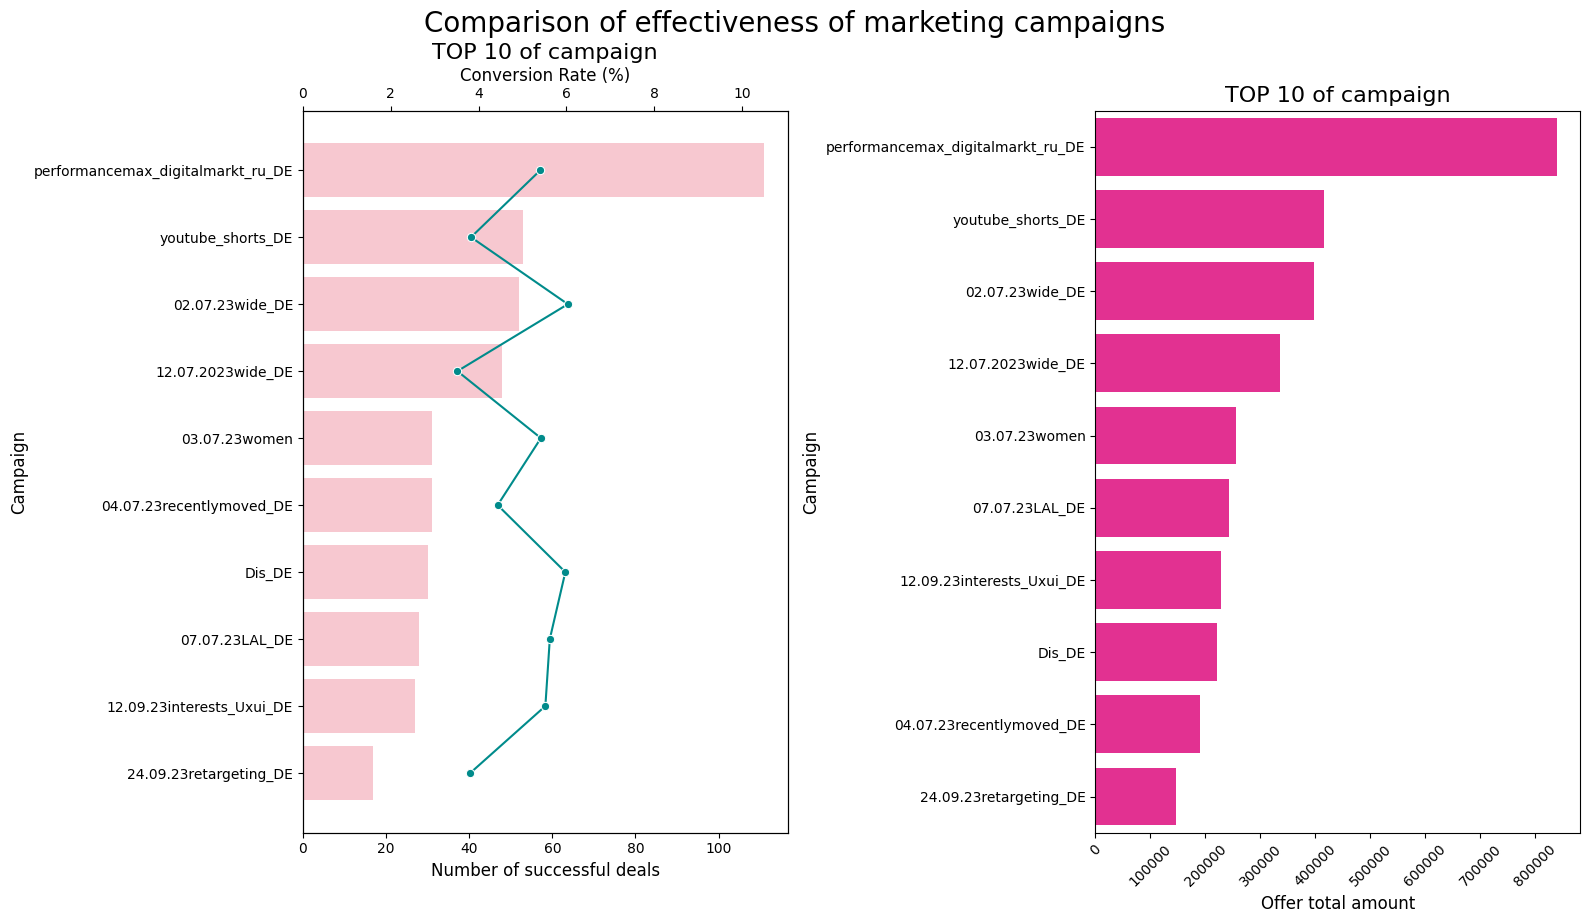

In [5]:
# Compare the efficiency of different campaigns in terms of lids generation and conversion ratio

# print(deals['Deals_Campaign'].nunique()) #too much campaigns

# take into account deals with paid and known campaign

campaign_deals = deals[deals['Deals_Campaign'] != 'Unknown'].groupby('Deals_Campaign', observed=True)['Deals_ID'].nunique().reset_index(name='Total_Deals')

successful_campaign_deals = deals[(deals['Stage'] == 'Payment Done') & (deals['Deals_Campaign'] != 'Unknown')].groupby('Deals_Campaign', observed=True)['Deals_ID'].nunique().reset_index(name='Successful_Deals')

total_successful_sales_campaign = deals[(deals['Stage'] == 'Payment Done') & (deals['Deals_Campaign'] != 'Unknown')].groupby('Deals_Campaign', observed=True)['Offer_Total_Amount'].sum().reset_index()

campaign_performance = pd.merge(campaign_deals, successful_campaign_deals, on='Deals_Campaign', how='left')
campaign_performance = pd.merge(campaign_performance, total_successful_sales_campaign, on='Deals_Campaign', how='left')

campaign_performance['Successful_Deals'] = campaign_performance['Successful_Deals'].fillna(0)
campaign_performance['Offer_Total_Amount'] = campaign_performance['Offer_Total_Amount'].fillna(0)

campaign_performance['Conversion_Rate'] = campaign_performance['Successful_Deals'] / campaign_performance['Total_Deals'] * 100

top_10_by_deals = campaign_performance.sort_values(by='Successful_Deals', ascending=False).head(10)
top_10_by_amount = campaign_performance.sort_values(by='Offer_Total_Amount', ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 9))

ax1=axes[0]
sns.barplot(x='Successful_Deals', y='Deals_Campaign', data=top_10_by_deals, ax=ax1, color = 'pink', orient='h', order=top_10_by_deals['Deals_Campaign'].tolist())
ax1.set_title('TOP 10 of campaign', fontsize=16)
ax1.set_xlabel('Number of successful deals', fontsize=12)
ax1.set_ylabel('Campaign', fontsize=12)
ax1.tick_params(axis='x')

ax2 = ax1.twiny()
sns.lineplot(x='Conversion_Rate', y='Deals_Campaign', data=top_10_by_deals, ax=ax2, color='darkcyan', marker='o', sort=False)
ax2.set_xlabel('Conversion Rate (%)', fontsize=12)
plt.xlim(0, top_10_by_deals['Conversion_Rate'].max() + 5)

ax3=axes[1]
sns.barplot(x='Offer_Total_Amount', y='Deals_Campaign', data=top_10_by_amount, ax=ax3, color = 'deeppink', orient='h', order=top_10_by_amount['Deals_Campaign'].tolist())
ax3.set_title('TOP 10 of сampaign', fontsize=16)
ax3.set_xlabel('Offer total amount', fontsize=12)
ax3.set_ylabel('Campaign', fontsize=12)
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Comparison of effectiveness of marketing campaigns', fontsize=20, y=1.02)
plt.savefig('Analysis_of_Campaign_Success.png')
plt.show()

In [6]:
print(top_10_by_deals)

                        Deals_Campaign  Total_Deals  Successful_Deals  \
116  performancemax_digitalmarkt_ru_DE         2053             111.0   
149                  youtube_shorts_DE         1384              53.0   
2                      02.07.23wide_DE          862              52.0   
18                   12.07.2023wide_DE         1364              48.0   
4                        03.07.23women          572              31.0   
5             04.07.23recentlymoved_DE          699              31.0   
60                              Dis_DE          502              30.0   
8                       07.07.23LAL_DE          498              28.0   
19           12.09.23interests_Uxui_DE          489              27.0   
40              24.09.23retargeting_DE          446              17.0   

     Offer_Total_Amount  Conversion_Rate  
116            839400.0         5.406722  
149            415500.0         3.829480  
2              396900.0         6.032483  
18             336400.0 

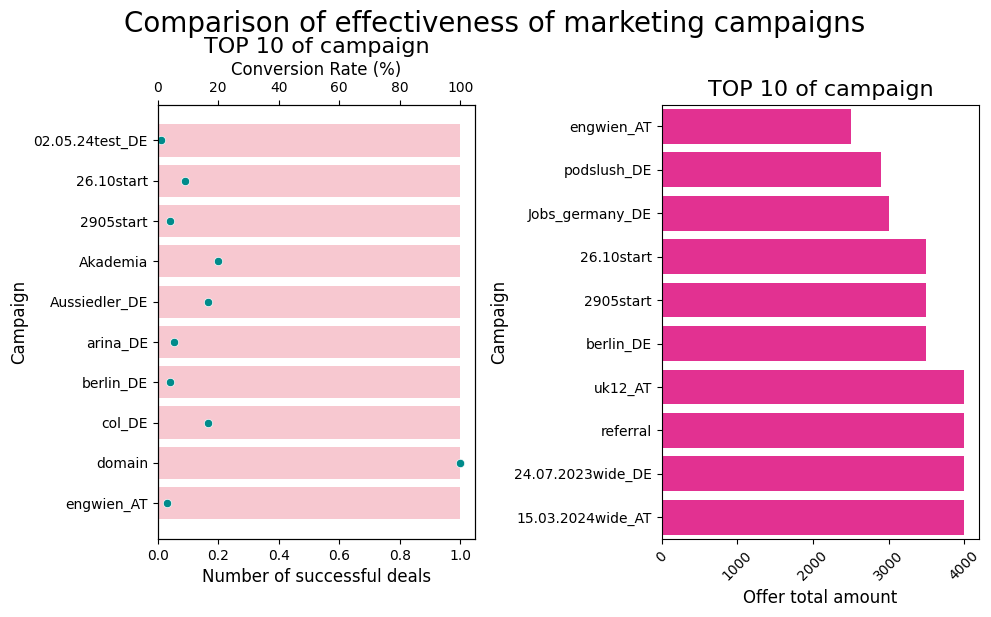

In [7]:
# Compare the efficiency of different campaigns in terms of lids generation and conversion ratio

# print(deals['Deals_Campaign'].nunique()) #too much campaigns

# take into account deals with paid and known campaign

campaign_deals = deals[deals['Deals_Campaign'] != 'Unknown'].groupby('Deals_Campaign', observed=True)['Deals_ID'].nunique().reset_index(name='Total_Deals')

successful_campaign_deals = deals[(deals['Stage'] == 'Payment Done') & (deals['Deals_Campaign'] != 'Unknown')].groupby('Deals_Campaign', observed=True)['Deals_ID'].nunique().reset_index(name='Successful_Deals')

total_successful_sales_campaign = deals[(deals['Stage'] == 'Payment Done') & (deals['Deals_Campaign'] != 'Unknown')].groupby('Deals_Campaign', observed=True)['Offer_Total_Amount'].sum().reset_index()

campaign_performance = pd.merge(campaign_deals, successful_campaign_deals, on='Deals_Campaign', how='left')
campaign_performance = pd.merge(campaign_performance, total_successful_sales_campaign, on='Deals_Campaign', how='left')

campaign_performance['Successful_Deals'] = campaign_performance['Successful_Deals'].fillna(0)
campaign_performance['Offer_Total_Amount'] = campaign_performance['Offer_Total_Amount'].fillna(0)

campaign_performance['Conversion_Rate'] = campaign_performance['Successful_Deals'] / campaign_performance['Total_Deals'] * 100

# show campaigns with low number of deals
campaign_performance_filtered = campaign_performance[campaign_performance['Successful_Deals'] > 0]

not_top_10_by_deals = campaign_performance_filtered.sort_values(by='Successful_Deals', ascending=True).head(10)
not_top_10_by_amount = campaign_performance_filtered.sort_values(by='Offer_Total_Amount', ascending=True).head(10)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

ax1=axes[0]
sns.barplot(x='Successful_Deals', y='Deals_Campaign', data=not_top_10_by_deals, ax=ax1, color='pink', order=not_top_10_by_deals['Deals_Campaign'].tolist())
ax1.set_title('TOP 10 of campaign', fontsize=16)
ax1.set_xlabel('Number of successful deals', fontsize=12)
ax1.set_ylabel('Campaign', fontsize=12)
ax1.tick_params(axis='x')

ax2 = ax1.twiny()
sns.scatterplot(x='Conversion_Rate', y='Deals_Campaign', data=not_top_10_by_deals, ax=ax2, color='darkcyan', marker='o')
ax2.set_xlabel('Conversion Rate (%)', fontsize=12)
plt.xlim(0, not_top_10_by_deals['Conversion_Rate'].max() + 5)

ax3=axes[1]
sns.barplot(x='Offer_Total_Amount', y='Deals_Campaign', data=not_top_10_by_amount, ax=ax3, color='deeppink', order=not_top_10_by_amount['Deals_Campaign'].tolist())
ax3.set_title('TOP 10 of сampaign', fontsize=16)
ax3.set_xlabel('Offer total amount', fontsize=12)
ax3.set_ylabel('Campaign', fontsize=12)
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Comparison of effectiveness of marketing campaigns', fontsize=20, y=1.02)
plt.savefig('Analysis_of_Campaign_Failure.png')
plt.show()

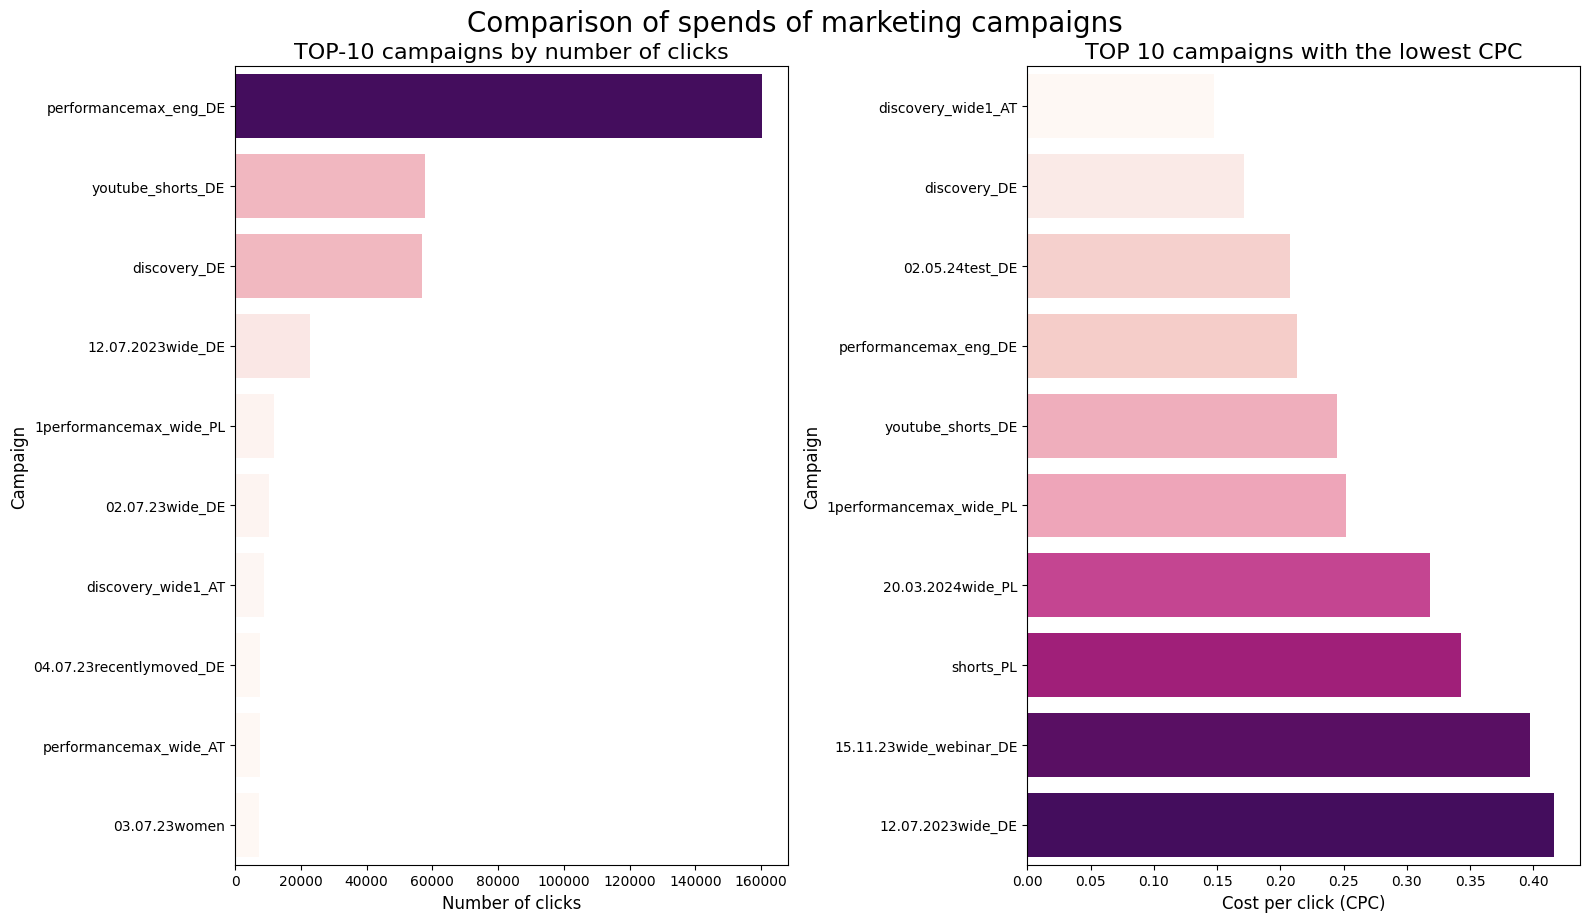

In [8]:
campaign_metrics = spend.groupby('Spend_Campaign',observed=True).agg(Total_Spend=('Spend', 'sum'),Total_Clicks=('Clicks', 'sum')).reset_index()

campaign_metrics = campaign_metrics[campaign_metrics['Spend_Campaign'].str.lower() != 'unknown'].copy()
campaign_metrics['Spend_Campaign'] = campaign_metrics['Spend_Campaign'].astype('category')
campaign_metrics['Spend_Campaign'] = campaign_metrics['Spend_Campaign'].cat.remove_unused_categories()

campaign_metrics['CPC'] = campaign_metrics['Total_Spend'] / campaign_metrics['Total_Clicks']

top_10_by_clicks = campaign_metrics.sort_values(by='Total_Clicks', ascending=False).head(10)
top_10_by_cpc = campaign_metrics.sort_values(by='CPC', ascending=True).head(10)
top_10_by_clicks['Spend_Campaign'] = top_10_by_clicks['Spend_Campaign'].cat.remove_unused_categories()
top_10_by_cpc['Spend_Campaign'] = top_10_by_cpc['Spend_Campaign'].cat.remove_unused_categories()

fig, axes = plt.subplots(1, 2, figsize=(16, 9))

sns.barplot(x='Total_Clicks', y='Spend_Campaign', data=top_10_by_clicks, ax=axes[0], palette='RdPu', legend = False, hue = 'Total_Clicks', order=top_10_by_clicks['Spend_Campaign'])
axes[0].set_title('ТOP-10 campaigns by number of clicks', fontsize=16)
axes[0].set_xlabel('Number of clicks', fontsize=12)
axes[0].set_ylabel('Campaign', fontsize=12)

sns.barplot(x='CPC', y='Spend_Campaign', data=top_10_by_cpc, ax=axes[1], palette='RdPu', legend = False, hue = 'CPC', order=top_10_by_cpc['Spend_Campaign'])
axes[1].set_title('TOP 10 campaigns with the lowest CPC', fontsize=16)
axes[1].set_xlabel('Cost per click (CPC)', fontsize=12)
axes[1].set_ylabel('Campaign', fontsize=12)

plt.tight_layout()
plt.suptitle('Comparison of spends of marketing campaigns', fontsize=20, y=1.02)
plt.savefig('Analysis_of_Campaign_Spend.png')
plt.show()

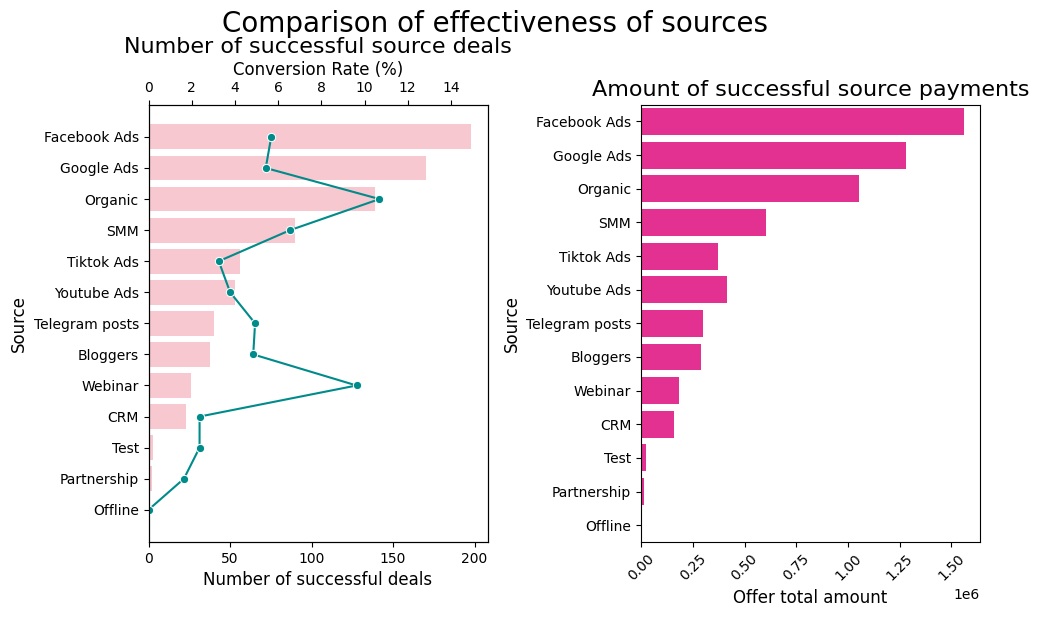

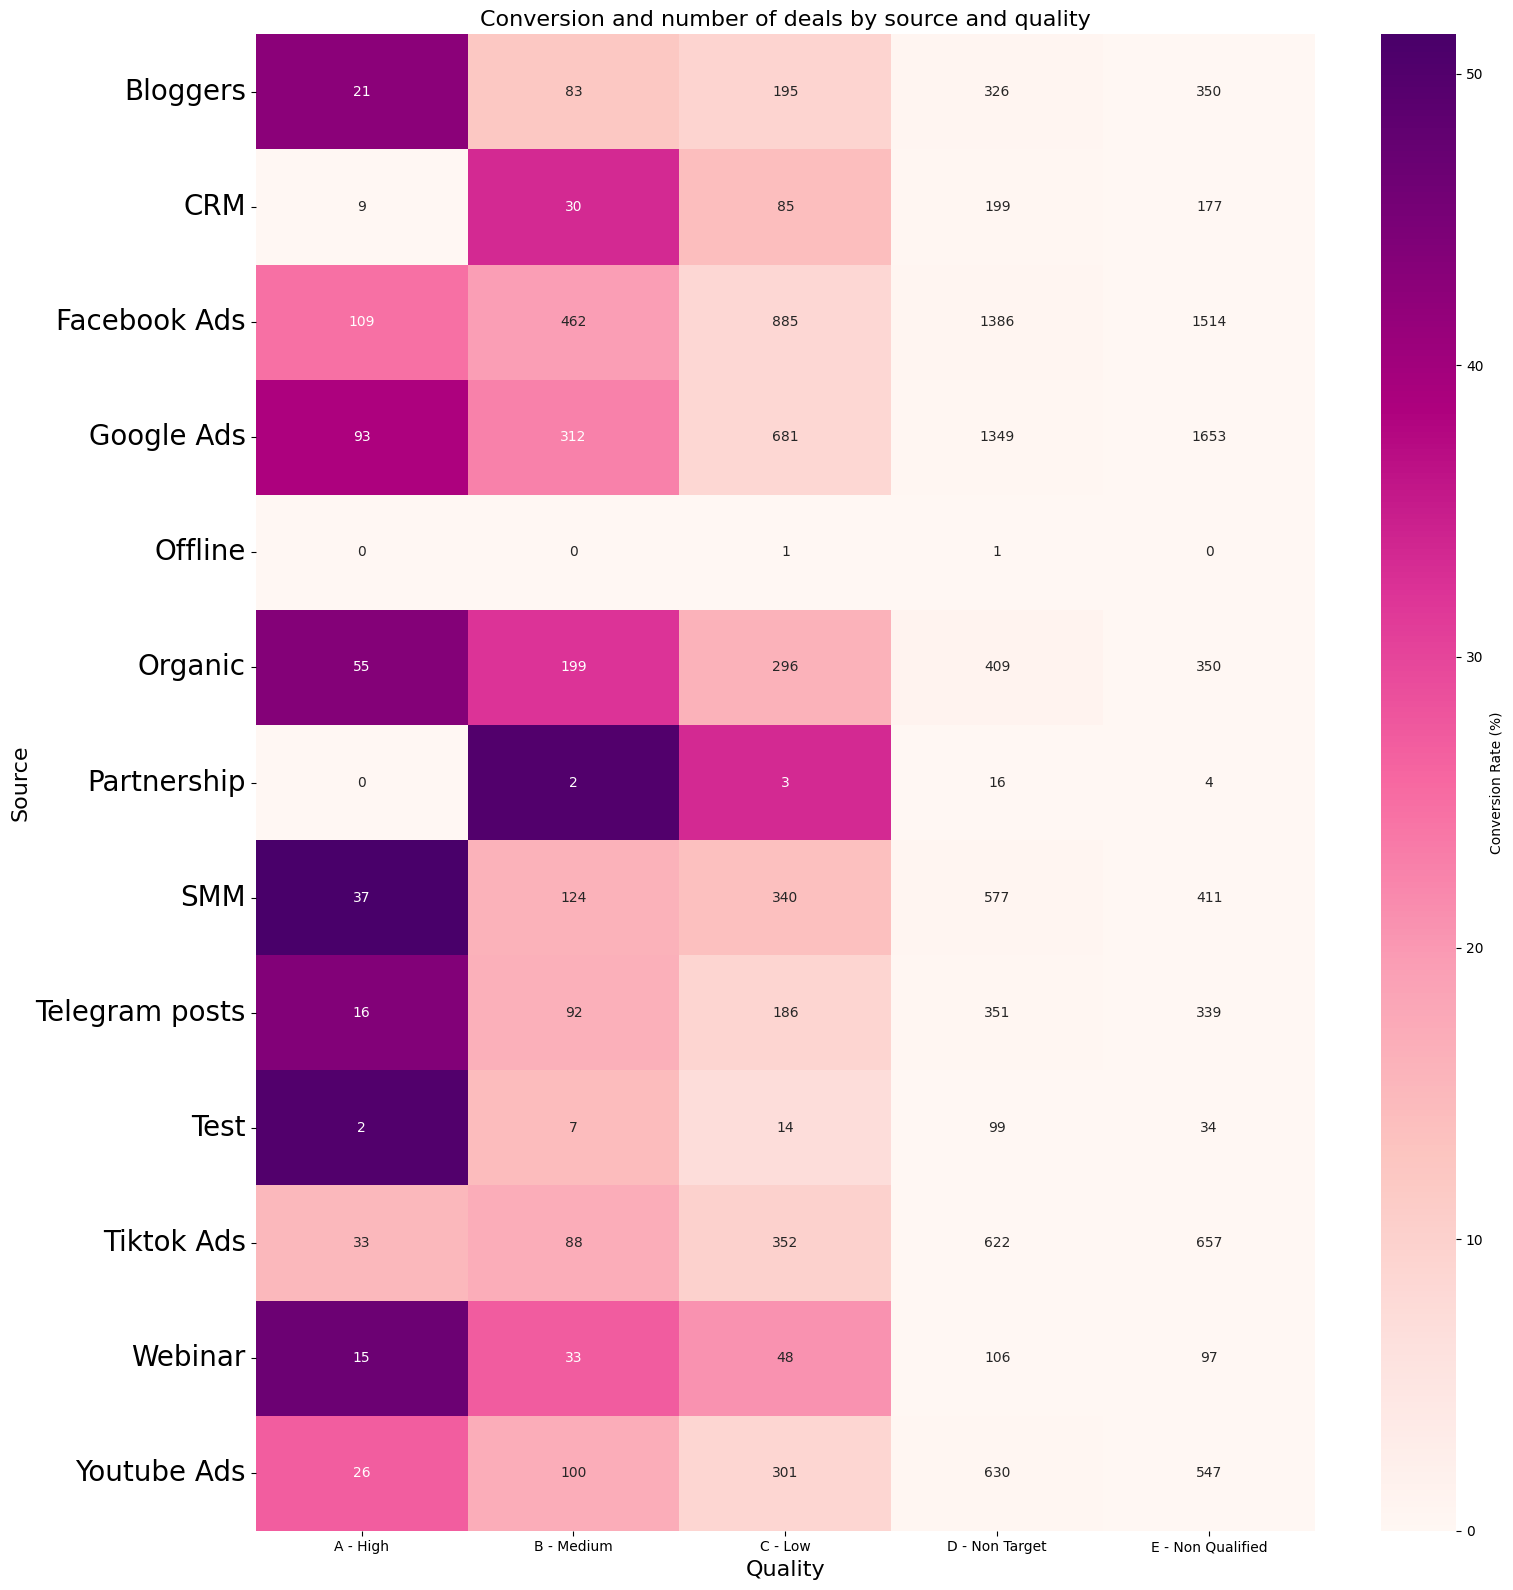

In [10]:
# Evaluate the effectiveness of various marketing sources (Source) in generating quality leads.

source_deals = deals[deals['Source'] != 'Unknown'].groupby('Source', observed=True)['Deals_ID'].nunique().reset_index(name='Total_Deals')

successful_source_deals = deals[(deals['Stage'] == 'Payment Done') & (deals['Source'] != 'Unknown')].groupby('Source', observed=True)['Deals_ID'].nunique().reset_index(name='Successful_Deals')

total_successful_sales_source = deals[(deals['Stage'] == 'Payment Done') & (deals['Source'] != 'Unknown')].groupby('Source', observed=True)['Offer_Total_Amount'].sum().reset_index()

source_performance = pd.merge(source_deals, successful_source_deals, on='Source', how='left')
source_performance = pd.merge(source_performance, total_successful_sales_source, on='Source', how='left')

source_performance['Successful_Deals'] = source_performance['Successful_Deals'].fillna(0)
source_performance['Offer_Total_Amount'] = source_performance['Offer_Total_Amount'].fillna(0)

source_performance['Conversion_Rate'] = (source_performance['Successful_Deals'] / source_performance['Total_Deals']) * 100

source_performance_sorted = source_performance.sort_values(by='Successful_Deals', ascending=False)
source_order = source_performance_sorted['Source']

source_performance_amount_sorted = source_performance.sort_values(by='Offer_Total_Amount', ascending=False)
source_amount_order = source_performance_sorted['Source']

fig_source, axes = plt.subplots(1, 2, figsize=(10, 6))

ax1=axes[0]
sns.barplot(x='Successful_Deals', y='Source', data=source_performance_sorted, ax=ax1, color = 'pink', orient='h', order = source_order)
ax1.set_title('Number of successful source deals', fontsize=16)
ax1.set_xlabel('Number of successful deals', fontsize=12)
ax1.set_ylabel('Source', fontsize=12)

ax2 = ax1.twiny()
sns.lineplot(x='Conversion_Rate', y='Source', data=source_performance_sorted, ax=ax2, marker='o', sort=False, color='darkcyan')
ax2.set_xlabel('Conversion Rate (%)', fontsize=12)
plt.xlim(0, source_performance_sorted['Conversion_Rate'].max() + 5)

ax3=axes[1]
sns.barplot(x='Offer_Total_Amount', y='Source', data=source_performance_amount_sorted, ax=ax3, color = 'deeppink', orient='h', order = source_amount_order)
ax3.set_title('Amount of successful source payments', fontsize=16)
ax3.set_xlabel('Offer total amount', fontsize=12)
ax3.set_ylabel('Source', fontsize=12)
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Comparison of effectiveness of sources', fontsize=20, y=1.02)
plt.savefig('Analysis_of_Source_Success.png')
plt.show()

deals_quality_source = deals[(deals['Source'] != 'Unknown')&(deals['Quality'] != 'F - Unknown')].copy()

deals_quality_source['Source'] = deals_quality_source['Source'].astype('category')
deals_quality_source['Quality'] = deals_quality_source['Quality'].astype('category')

deals_quality_source['Source'] = deals_quality_source['Source'].cat.remove_unused_categories()
deals_quality_source['Quality'] = deals_quality_source['Quality'].cat.remove_unused_categories()

heatmap_data_pivot = deals_quality_source.groupby(['Source', 'Quality'], observed=True).agg(Total_Deals=('Deals_ID', 'count'),Successful_Deals=('Stage', lambda x: (x == 'Payment Done').sum())).reset_index()

heatmap_data_pivot['Conversion_Rate'] = (heatmap_data_pivot['Successful_Deals'] / heatmap_data_pivot['Total_Deals']) * 100

heatmap_conv = heatmap_data_pivot.pivot_table(index='Source', columns='Quality', values='Conversion_Rate').fillna(0)
heatmap_count = heatmap_data_pivot.pivot_table(index='Source', columns='Quality', values='Total_Deals').fillna(0)

plt.figure(figsize=(16, 16))
sns.heatmap(heatmap_conv, annot=heatmap_count, fmt='.0f', cmap='RdPu', cbar_kws={'label': 'Conversion Rate (%)'})
plt.title('Conversion and number of deals by source and quality', fontsize=16)
plt.xlabel('Quality', fontsize=16)
plt.ylabel('Source', fontsize=16)
plt.yticks(fontsize=20,rotation=0)
plt.tight_layout()
plt.savefig('Analysis_of_Source_Quality.png')
plt.show()

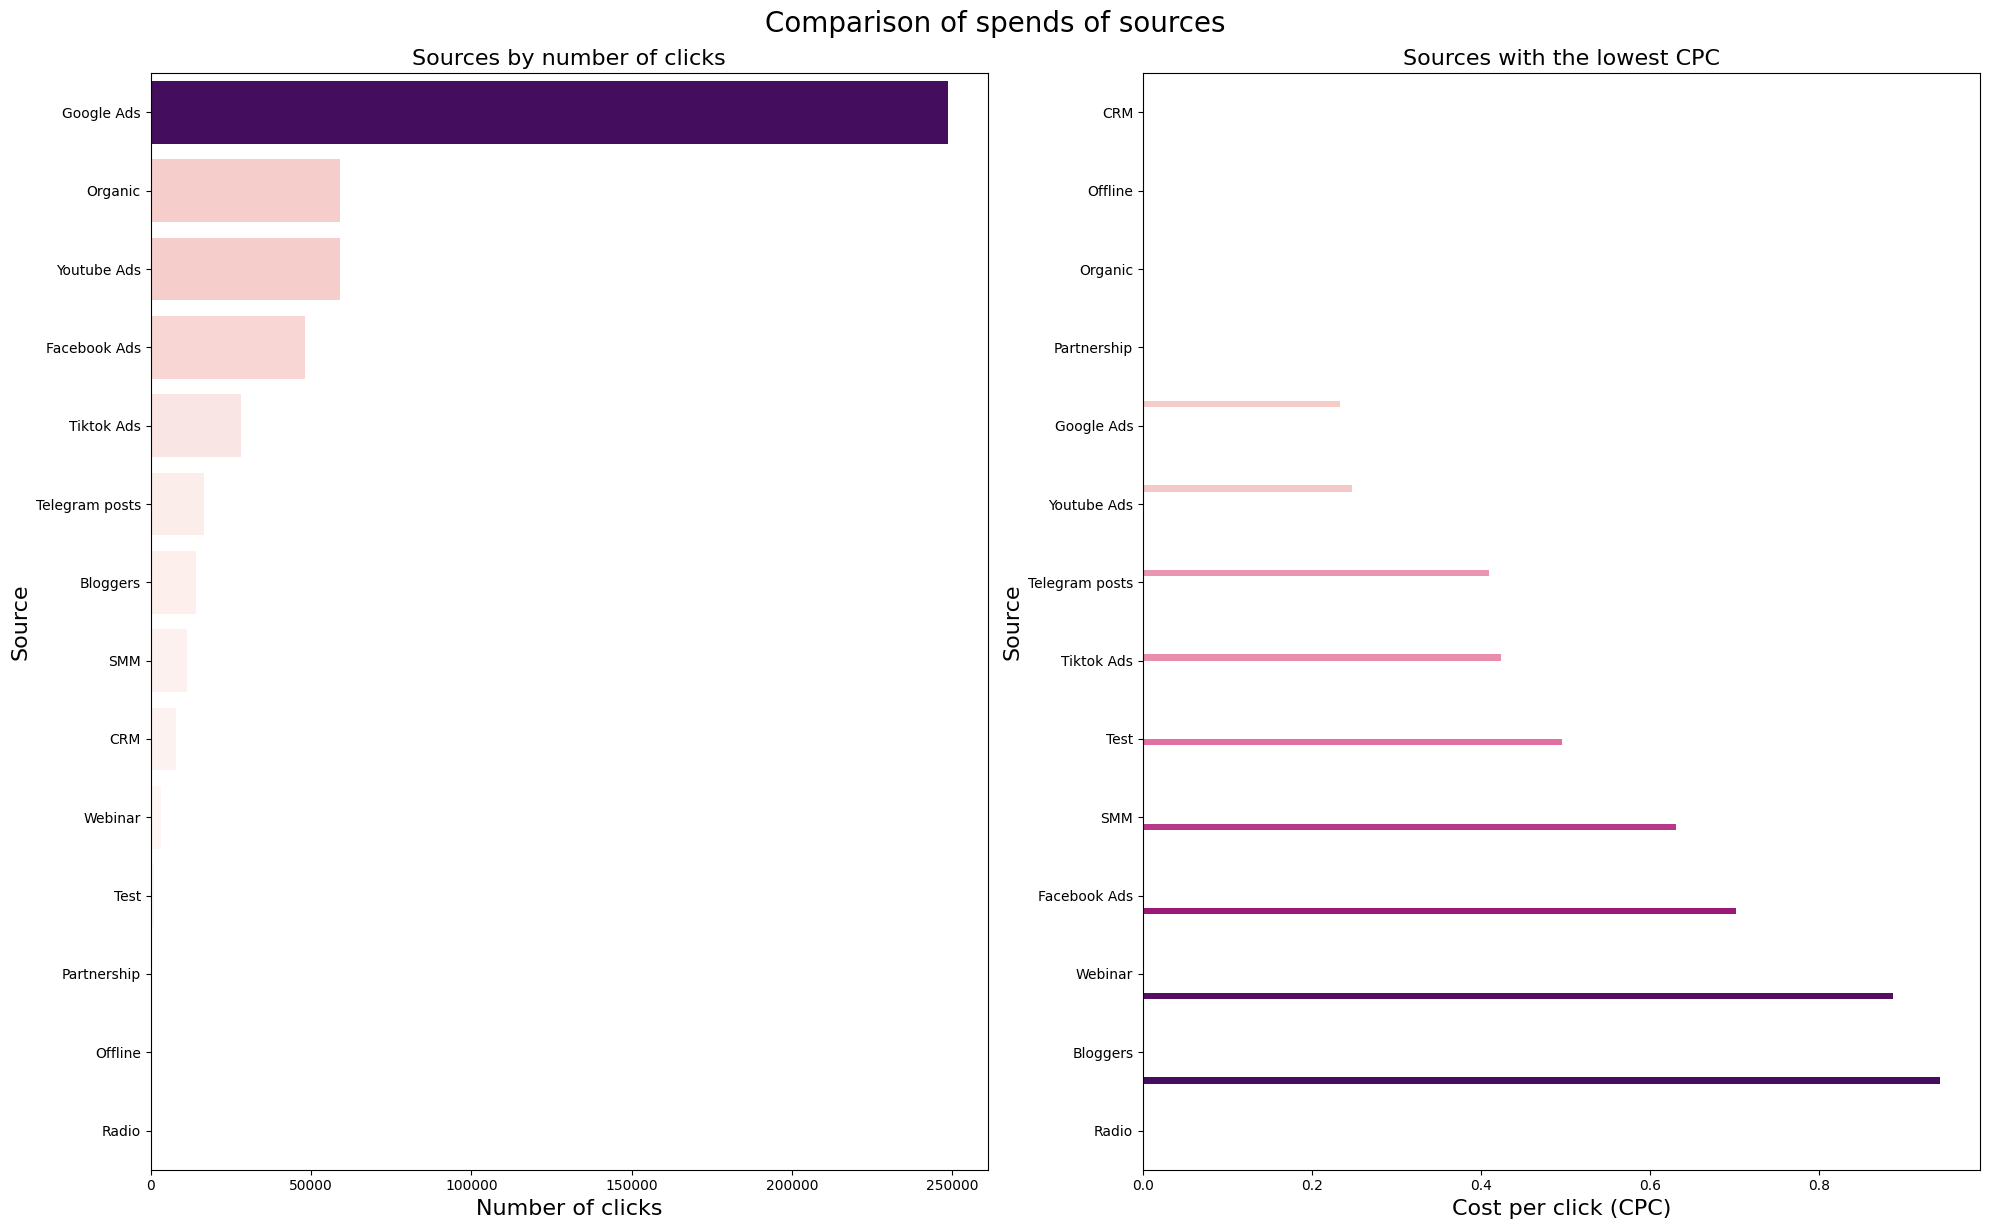

In [11]:
#spend analysis
source_metrics = spend.groupby('Spend_Source',observed=True).agg(Total_Spend=('Spend', 'sum'),Total_Clicks=('Clicks', 'sum')).reset_index()

source_metrics = source_metrics[source_metrics['Spend_Source'] != 'Unknown'].copy()
source_metrics['Spend_Source'] = source_metrics['Spend_Source'].astype('category')
source_metrics['Spend_Source'] = source_metrics['Spend_Source'].cat.remove_unused_categories()

source_metrics['CPC'] = np.where(source_metrics['Total_Clicks'] > 0, source_metrics['Total_Spend'] / source_metrics['Total_Clicks'], np.nan)

sorted_by_clicks = source_metrics.sort_values(by='Total_Clicks', ascending=False)
sorted_by_cpc = source_metrics.sort_values(by='CPC', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(20, 12))

sns.barplot(x='Total_Clicks', y='Spend_Source', data=sorted_by_clicks, ax=axes[0], hue = 'Total_Clicks', legend=False, palette='RdPu', order=sorted_by_clicks['Spend_Source'])
axes[0].set_title('Sources by number of clicks', fontsize=16)
axes[0].set_xlabel('Number of clicks', fontsize=16)
axes[0].set_ylabel('Source', fontsize=16)

sns.barplot(x='CPC', y='Spend_Source', data=sorted_by_cpc, ax=axes[1], hue = 'CPC', legend=False, palette='RdPu',order=sorted_by_cpc['Spend_Source'])
axes[1].set_title('Sources with the lowest CPC', fontsize=16)
axes[1].set_xlabel('Cost per click (CPC)', fontsize=16)
axes[1].set_ylabel('Source', fontsize=16)

plt.tight_layout()
plt.suptitle('Comparison of spends of sources', fontsize=20, y=1.02)
plt.savefig('Analysis_of_Se_Quality.png')
plt.show()

## Analysis of sales department performance:

##### Summary:

- ###### Charlie Davis has the biggest amount of total deals
- ###### Leaders by number of successful deals -- Charlie Davis & Ulysses Adams
- ###### Leaders by profit - Charlie Davis & Ulysses Adams
- ###### Oliver Taylor has the highest conversion rate
- ###### Campaign has little impact on managers' performance

##### use Oliver Taylor strategy to retain client
##### it is necessary to analyze the number of deals by time for managers, because some of them may not work long and have low returns or number of transactions
##### leaders in number of deals have average conversion
##### pay attention to the work of Rachel White & Bob Brown (other managers with a similar number of deals have non-zero conversion)
##### according to previous stage of analysis, pay attention to the work of John Doe & Fiona Jackson (have too much missed calls)
##### as one of the causes of customer loss - no response and wrong phone number, it is worth rethinking ways to communicate with the client, also considering that the need for calls is decreasing. for example, use channels with the necessary registration through existing account in telegram, whatsaüü or where you just need to go to the application

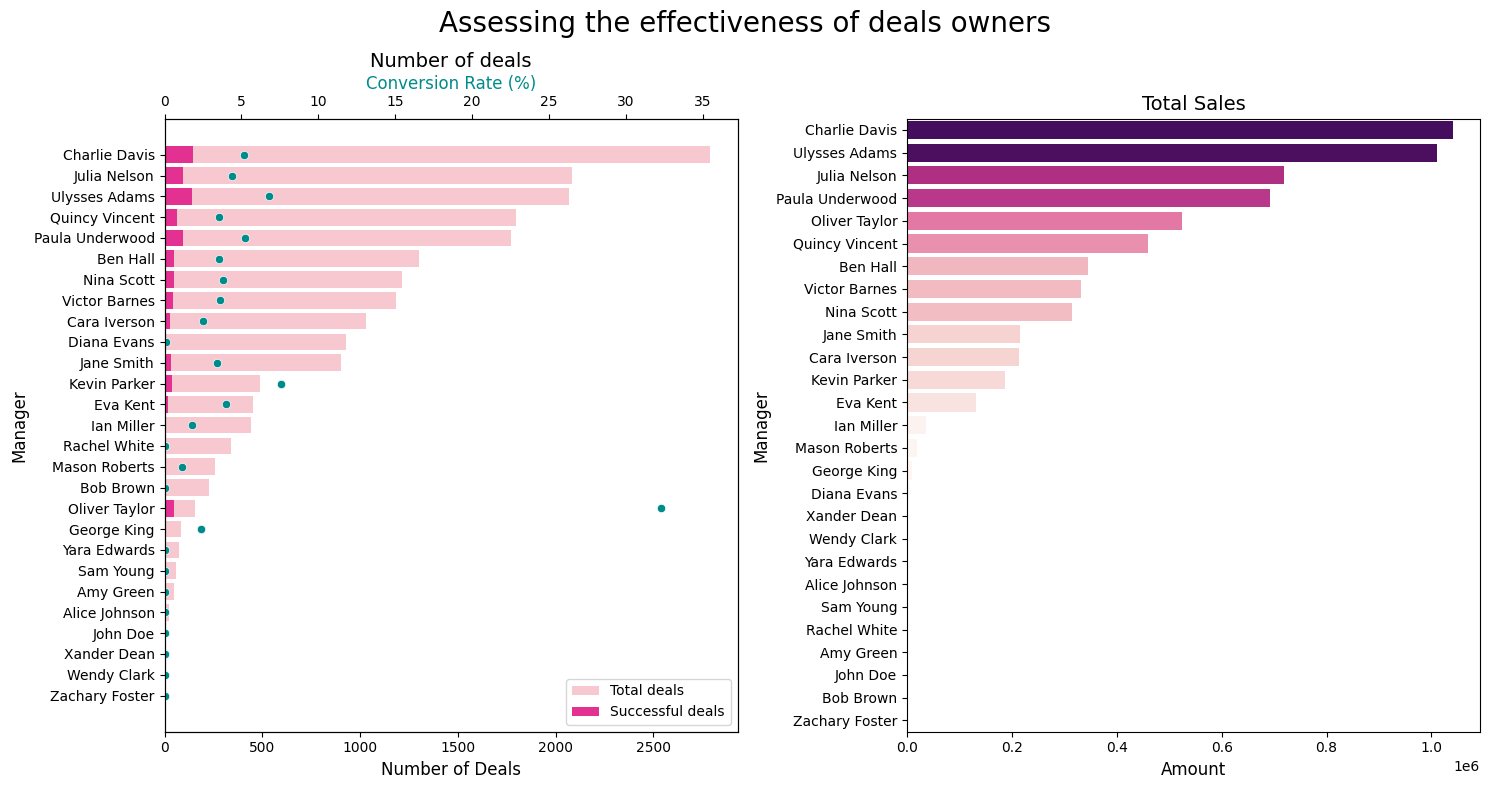

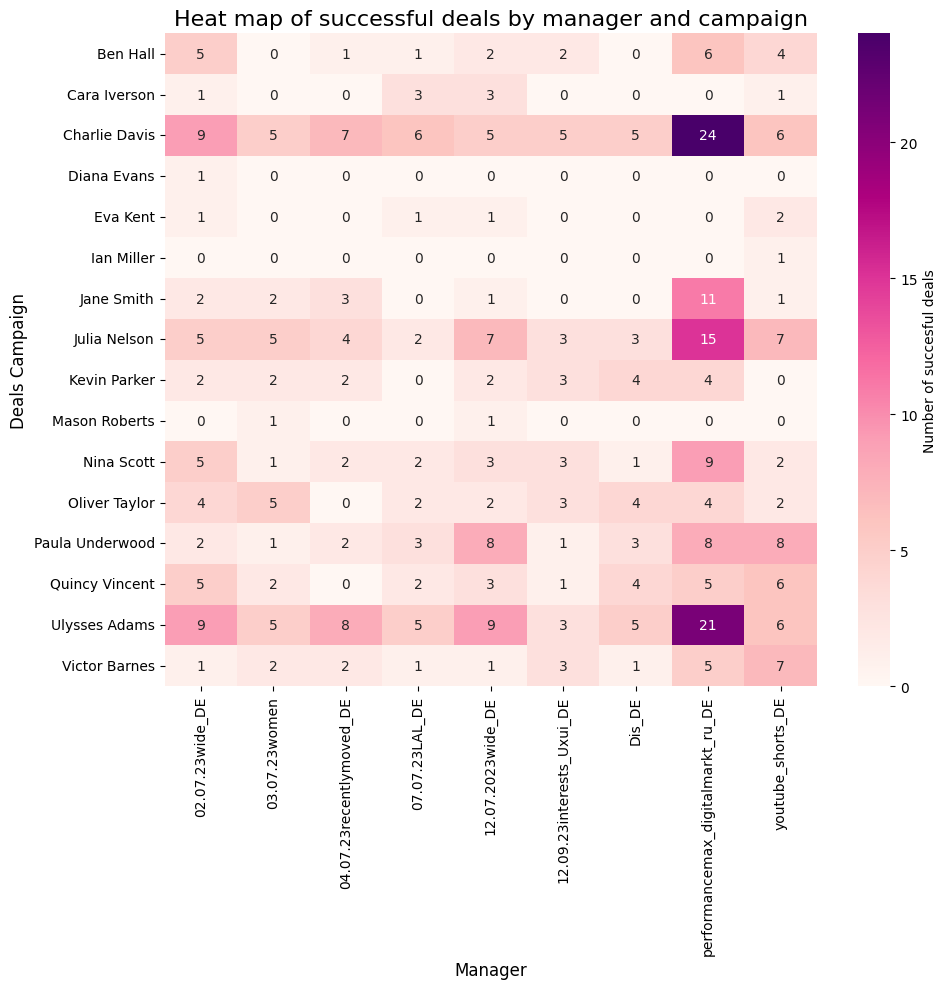

      Deals_Manager  Tenure
0     Alice Johnson      26
1         Amy Green      19
2          Ben Hall      25
3         Bob Brown      26
4      Cara Iverson      24
5     Charlie Davis      26
6       Diana Evans      26
7          Eva Kent      17
8       George King      26
9        Ian Miller      26
10       Jane Smith      26
11         John Doe      24
12     Julia Nelson      26
13     Kevin Parker      26
14    Mason Roberts      26
15       Nina Scott      26
16    Oliver Taylor      26
17  Paula Underwood      25
18   Quincy Vincent      26
19     Rachel White      26
20        Sam Young      21
21    Ulysses Adams      26
22          Unknown      26
23    Victor Barnes      26
24      Wendy Clark      20
25      Xander Dean      19
26     Yara Edwards      23
27   Zachary Foster      19


In [12]:
# Evaluate the effectiveness of individual deal owners and advertising campaigns in terms of number of deals processed, conversion rate and total sales.

deals_filtered_manager = deals[deals['Deals_Manager'] != 'Unknown'].copy()
deals_filtered_manager['Deals_Manager'] = deals_filtered_manager['Deals_Manager'].cat.remove_unused_categories()

deals_by_owner = deals_filtered_manager.groupby('Deals_Manager', observed=False).agg(Total_Deals=('Deals_ID', 'count'),Successful_Deals=('Stage', lambda x: (x == 'Payment Done').sum()),).reset_index()

successful_deals = deals_filtered_manager[deals_filtered_manager['Stage'] == 'Payment Done']
sales_by_owner = successful_deals.groupby('Deals_Manager', observed=False).agg(Total_Sales=('Offer_Total_Amount', 'sum')).reset_index()

deals_by_owner = deals_by_owner.merge(sales_by_owner, on='Deals_Manager', how='left')
deals_by_owner['Total_Sales'] = deals_by_owner['Total_Sales'].fillna(0)

deals_by_owner['Conversion_Rate'] = (deals_by_owner['Successful_Deals'] / deals_by_owner['Total_Deals']).fillna(0) * 100

deals_by_owner_deals = deals_by_owner.sort_values(by='Total_Deals', ascending=False)
deals_by_owner_sales = deals_by_owner.sort_values(by='Total_Sales', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle('Assessing the effectiveness of deals owners', fontsize=20)

ax1=axes[0]
sns.barplot(x='Total_Deals', y='Deals_Manager', data=deals_by_owner_deals, color='pink', label='Total deals', ax=ax1, order=deals_by_owner_deals['Deals_Manager'])
sns.barplot(x='Successful_Deals', y='Deals_Manager', data=deals_by_owner_deals, color='deeppink', label='Successful deals', ax=ax1, order=deals_by_owner_deals['Deals_Manager'])
ax1.set_title('Number of deals', fontsize=14)
ax1.set_xlabel('Number of Deals', fontsize=12)
ax1.set_ylabel('Manager', fontsize=12)
ax1.legend(loc='lower right')

ax2 = ax1.twiny()
sns.scatterplot(x='Conversion_Rate', y ='Deals_Manager', data=deals_by_owner_deals, color='darkcyan', marker='o', ax=ax2)
ax2.set_xlabel('Conversion Rate (%)', fontsize=12, color='darkcyan')
plt.xlim(0, deals_by_owner_deals['Conversion_Rate'].max() + 5)

ax3 = axes[1]
sns.barplot(x='Total_Sales', y='Deals_Manager',data=deals_by_owner_sales, palette='RdPu', hue='Total_Sales', ax=ax3, order=deals_by_owner_sales['Deals_Manager'], legend=False)
ax3.set_title('Total Sales', fontsize=14)
ax3.set_xlabel('Amount', fontsize=12)
ax3.set_ylabel('Manager', fontsize=12)

plt.tight_layout()
plt.savefig('Analysis_of_Manager_Success.png')
plt.show()

successful_deals_heatmap = deals[deals['Stage'] == 'Payment Done'].copy()
successful_deals_heatmap = successful_deals_heatmap[(successful_deals_heatmap['Deals_Manager'] != 'Unknown')&(successful_deals_heatmap['Deals_Campaign'] != 'Unknown')]

successful_deals_heatmap['Deals_Manager'] = successful_deals_heatmap['Deals_Manager'].cat.remove_unused_categories()
successful_deals_heatmap['Deals_Campaign'] = successful_deals_heatmap['Deals_Campaign'].cat.remove_unused_categories()

top_10_campaigns = successful_deals['Deals_Campaign'].value_counts().nlargest(10).index
successful_deals_top_10 = successful_deals_heatmap[successful_deals_heatmap['Deals_Campaign'].isin(top_10_campaigns)]

heatmap_manager_campaign = successful_deals_top_10.groupby(['Deals_Manager', 'Deals_Campaign'], observed=True).agg(Successful_Deals=('Deals_ID', 'count')).reset_index()
pivot_table_mc = heatmap_manager_campaign.pivot_table(index='Deals_Manager',columns='Deals_Campaign',values='Successful_Deals').fillna(0)

plt.figure(figsize=(10, 10))
sns.heatmap(pivot_table_mc, annot=True, fmt=".0f", cmap="RdPu", cbar_kws={'label': 'Number of succesful deals'})
plt.title('Heat map of successful deals by manager and campaign', fontsize=16)
plt.xlabel('Manager', fontsize=12)
plt.ylabel('Deals Campaign', fontsize=12)
plt.tight_layout()
plt.savefig('Manager_Campaign_Heatmap.png')
plt.show()

def calculate_manager_tenure(deals_df):
    
    first_deal_date = deals_df.groupby('Deals_Manager',observed=True)['Created_Time'].min().reset_index()
    first_deal_date['Tenure_Days'] = (pd.Timestamp.now() - first_deal_date['Created_Time']).dt.days
    first_deal_date['Tenure_Months'] = first_deal_date['Tenure_Days'] // 30
    
    return first_deal_date[['Deals_Manager', 'Tenure_Months']].rename(columns={'Tenure_Months': 'Tenure'})

tenure_df = calculate_manager_tenure(deals)
print(tenure_df)

## Analysis of payments and products:

##### Summary:

- ###### Maximum conversion observed for one-time payment
- ###### The maximum number of deals, including successful and profit is observed for recurring payments

##### remove reservation as payment type
##### promote the most successful type of payment - reccuring payment, because it is not even very inferior to the leader in conversion, as well as some of the lost clients had financial problems

##### Summary:

- ###### Conversion is approximately the same for all products
- ###### Maximum quantity deals, including successful ones for Digital Marketing
- ###### Evening products conversion above
- ###### Number of deals, including successful ones above for the morning type of training

##### because one of the reasons for losing a client -- choosing another school, choosing another direction that this school does not have, and also financial difficulties, try to develop other large programs in the morning because they attract more clients as well as small courses (for example, separately by subject from the general course) in the evening because they have high conversion and may be attractive for employed people

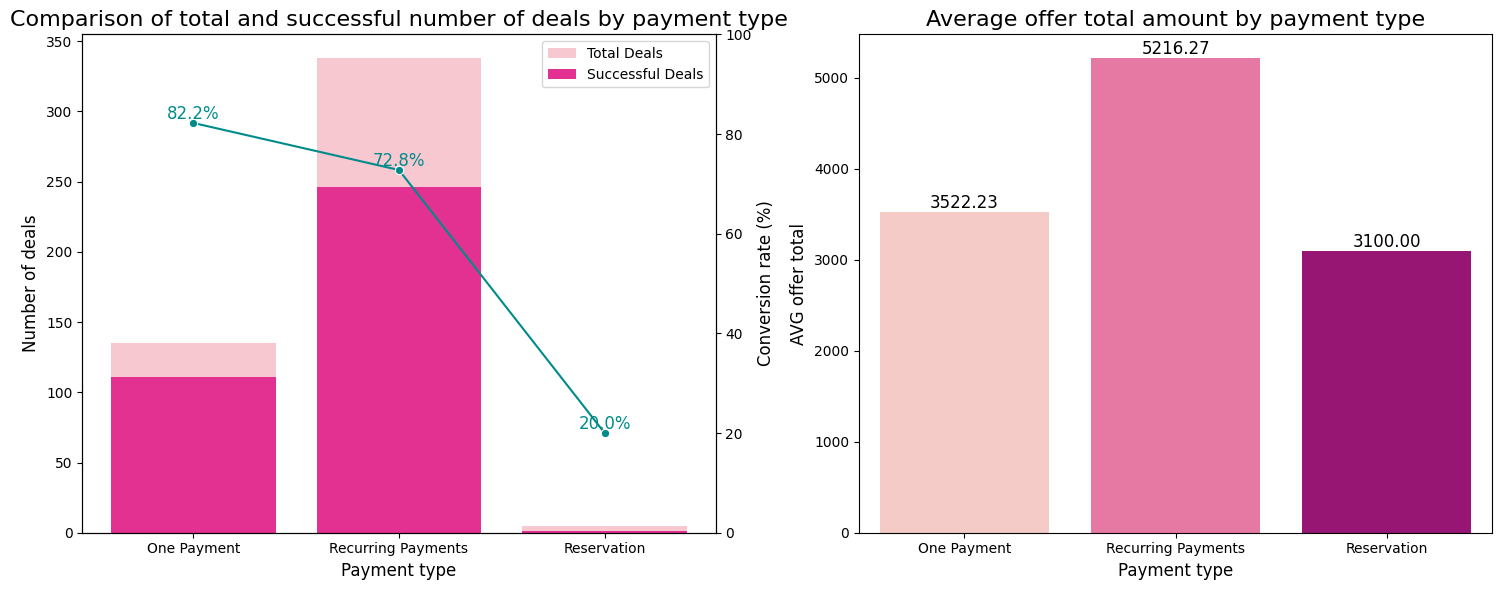

In [13]:
# Study the distribution of payment types and their impact on the success of transactions.

deals_filtered_payment = deals[(deals['Payment_Type'].notnull())&(deals['Payment_Type'] != 'Unknown')].copy()
deals_filtered_payment['Payment_Type'] = deals_filtered_payment['Payment_Type'].cat.remove_unused_categories()

total_deals = deals_filtered_payment['Payment_Type'].value_counts().reset_index()
total_deals.columns = ['Payment_Type', 'Total_CNT']

deals_filtered_success = deals_filtered_payment[deals_filtered_payment['Stage'] == 'Payment Done']
successful_deals = deals_filtered_success['Payment_Type'].value_counts().reset_index()
successful_deals.columns = ['Payment_Type', 'Successful_CNT']

average_amount = deals_filtered_payment.groupby('Payment_Type', observed=True)['Offer_Total_Amount'].mean().reset_index()
average_amount.columns = ['Payment_Type', 'AVG_Amount']

deals_payment = pd.merge(total_deals, successful_deals, on = 'Payment_Type', how = 'left')
deals_payment = pd.merge(deals_payment, average_amount, on='Payment_Type', how='left')
deals_payment['Successful_CNT'] = deals_payment['Successful_CNT'].astype(int)

deals_payment['Conversion_Rate'] = (deals_payment['Successful_CNT'] / deals_payment['Total_CNT']) * 100

deals_payment = deals_payment.sort_values(by='Payment_Type').reset_index(drop=True)
payment_order = deals_payment['Payment_Type']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ax1=axes[0]

sns.barplot(x='Payment_Type', y='Total_CNT', data=deals_payment, color='pink', label='Total Deals', ax=ax1, order = payment_order)
sns.barplot(x='Payment_Type', y='Successful_CNT', data=deals_payment, color='deeppink', label='Successful Deals', ax=ax1, order = payment_order)
ax1.set_title('Comparison of total and successful number of deals by payment type', fontsize=16)
ax1.set_xlabel('Payment type', fontsize=12)
ax1.set_ylabel('Number of deals', fontsize=12)
ax1.tick_params(axis='x')
ax1.legend()
# ax1.set_ylim(0, deals_payment['Total_CNT'].max() * 1.1)

ax2 = ax1.twinx()
sns.lineplot(x='Payment_Type', y='Conversion_Rate', data=deals_payment, color = 'darkcyan', marker = 'o' , ax=ax2, legend=False)
ax2.set_ylim(0, 100)
ax2.set_ylabel('Conversion rate (%)', fontsize=12)
ax2.set_ylim(0, 100)
ax2.tick_params(axis='x')
for index, row in deals_payment.iterrows():
    ax2.text(index, row['Conversion_Rate'], f"{row['Conversion_Rate']:.1f}%", ha='center', va = 'bottom', fontsize=12, color='darkcyan')

ax3=axes[1]
sns.barplot(x='Payment_Type', y='AVG_Amount', data=deals_payment, hue='Payment_Type', palette='RdPu', ax=ax3, legend=False, order = payment_order)
for index, row in deals_payment.iterrows():
    ax3.text(index, row['AVG_Amount'], f"{row['AVG_Amount']:.2f}", ha='center', va='bottom', fontsize=12)

ax3.set_title('Average offer total amount by payment type', fontsize=16)
ax3.set_xlabel('Payment type', fontsize=12)
ax3.set_ylabel('AVG offer total', fontsize=12)
ax3.tick_params(axis='x')

plt.tight_layout()
plt.savefig('Analysis_of_Payment_Type_Success.png')
plt.show()

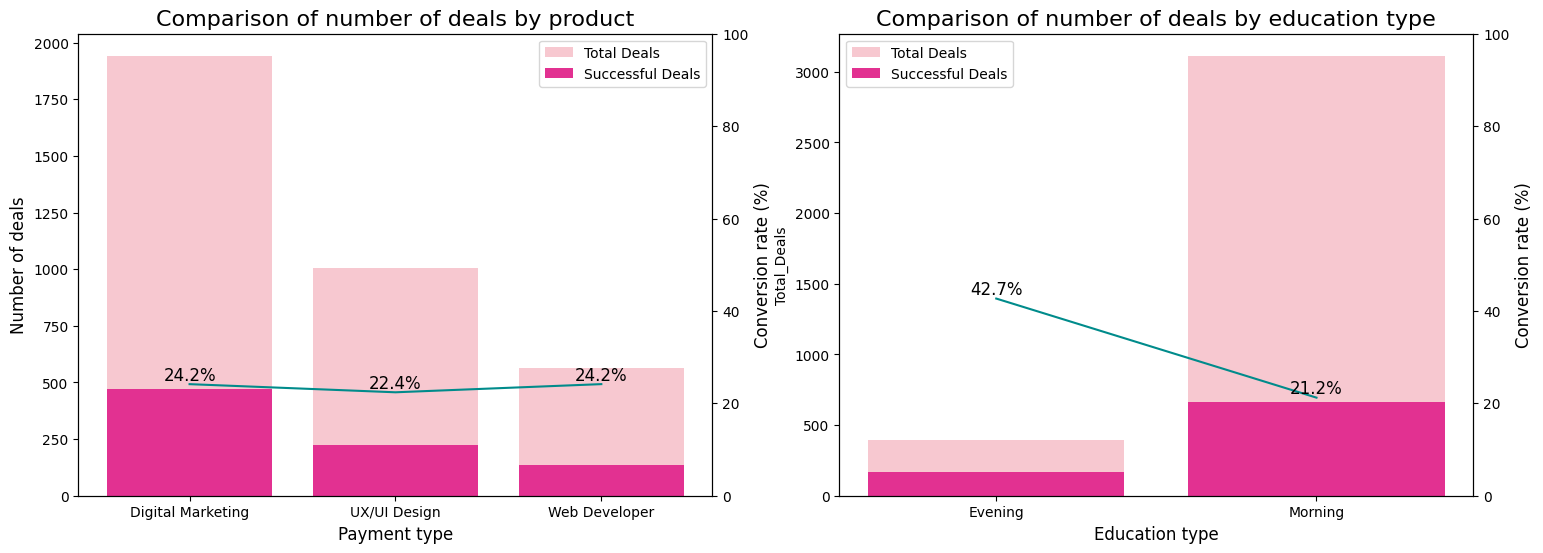

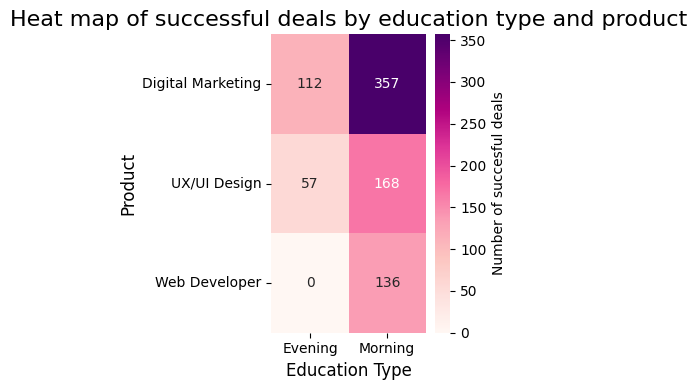

In [18]:
# Analyze the popularity and success of different products and types of training

deals_filtered_pet = deals[(deals['Education_Type'] != 'Unknown') & (deals['Product'] != 'Unknown')].copy()
deals_filtered_pet['Education_Type'] = deals_filtered_pet['Education_Type'].cat.remove_unused_categories()
deals_filtered_pet['Product'] = deals_filtered_pet['Product'].cat.remove_unused_categories()

deals_by_education_type = deals_filtered_pet.groupby('Education_Type',observed=True).agg(Total_Deals=('Deals_ID', 'count'), Successful_Deals=('Stage', lambda x: (x == 'Payment Done').sum())).reset_index()

deals_by_education_type['Conversion_Rate'] = (deals_by_education_type['Successful_Deals'] / deals_by_education_type['Total_Deals']).fillna(0) * 100

deals_by_product = deals_filtered_pet.groupby('Product',observed=True).agg(Total_Deals=('Deals_ID', 'count'), Successful_Deals=('Stage', lambda x: (x == 'Payment Done').sum())).reset_index()

deals_by_product['Conversion_Rate'] = (deals_by_product['Successful_Deals'] / deals_by_product['Total_Deals']).fillna(0) * 100

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

ax1=axes[0]
sns.barplot(x='Product', y='Total_Deals', data=deals_by_product, color='pink', label='Total Deals', ax=ax1)
sns.barplot(x='Product', y='Successful_Deals', data=deals_by_product, color='deeppink', label='Successful Deals', ax=ax1)
ax1.set_title('Comparison of number of deals by product', fontsize=16)
ax1.set_xlabel('Payment type', fontsize=12)
ax1.set_ylabel('Number of deals', fontsize=12)
ax1.tick_params(axis='x')
ax1.legend()

ax2 = ax1.twinx()
sns.lineplot(x='Product', y='Conversion_Rate', data=deals_by_product, color='darkcyan', ax=ax2, legend=False, sort=False)
for index, row in deals_by_product.iterrows():
    ax2.text(index, row['Conversion_Rate'], f"{row['Conversion_Rate']:.1f}%", ha='center', va='bottom', fontsize=12)
ax2.set_ylabel('Conversion rate (%)', fontsize=12)
ax2.set_ylim(0, 100)
ax2.tick_params(axis='x')

ax3=axes[1]
sns.barplot(x='Education_Type', y='Total_Deals', data=deals_by_education_type, color='pink', label='Total Deals', ax=ax3)
sns.barplot(x='Education_Type', y='Successful_Deals', data=deals_by_education_type, color='deeppink', label='Successful Deals', ax=ax3)
ax3.set_title('Comparison of number of deals by education type', fontsize=16)
ax3.set_xlabel('Education type', fontsize=12)
ax3.tick_params(axis='x')
ax3.legend()

ax4 = ax3.twinx()
sns.lineplot(x='Education_Type', y='Conversion_Rate', data=deals_by_education_type, color='darkcyan', ax=ax4, legend=False, sort=False)
for index, row in deals_by_education_type.iterrows():
    ax4.text(index, row['Conversion_Rate'], f"{row['Conversion_Rate']:.1f}%", ha='center', va='bottom', fontsize=12)
ax4.set_ylabel('Conversion rate (%)', fontsize=12)
ax4.set_ylim(0, 100)
ax4.tick_params(axis='x')
plt.savefig('Products_and_Education_Types.png')
plt.show()

heatmap_data = deals_filtered_pet[deals_filtered_pet['Stage'] == 'Payment Done'].groupby(['Education_Type', 'Product'],observed=True).agg(Successful_Deals=('Deals_ID', 'count')).reset_index()

pivot_table = heatmap_data.pivot_table(index='Product', columns='Education_Type', values='Successful_Deals').fillna(0)

plt.figure(figsize=(4, 4))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="RdPu", cbar_kws={'label': 'Number of succesful deals'})
plt.title('Heat map of successful deals by education type and product', fontsize=16)
plt.xlabel('Education Type', fontsize=12)
plt.xticks(rotation = 0)
plt.ylabel('Product', fontsize=12)
plt.tight_layout()
plt.savefig('Products_and_Education_Types_Heatmap.png')
plt.show()

## Geographic analysis:

##### Summary:

- ###### All the cities listed by number of deals are in Germany
- ###### maximum number of deals, including successful ones, in major cities
- ###### conversion does not depend directly on the size of the city
- ###### Medium quality ledges have the highest conversion on average
- ###### high conversion is also observed in the German-speaking Vienna - the capital of Austria

##### in small cities conversion may be higher, but the number of transactions will not be as high as in large ones due to population size
##### Strengthening marketing in the top conversion cities, where there were already at least 5 successful deals, and also in the top cities by number of deals with conversions above average
###### P.S. map failed to build ((

##### Summary:

- ###### the majority of clients who have made successful deals have a German level b1
- ###### practically not seen people with level less than a2 and more than b2
- ###### distribution of language level approximately the same in all cities

##### to increase the likelihood of state funding, additional German language classes can be introduced to improve employment chances
##### it is possible to expand the niche by developing courses on technical German for professionals in programming, but beginners in the German market

In [ ]:
# Analyze the geographic distribution of deals by cities

deals_cities = deals[deals['City']!='Unknown'].copy()
deals_cities['City'] = deals_cities['City'].astype('category')
deals_cities['City'] = deals_cities['City'].cat.remove_unused_categories()

deals_by_city = deals_cities.groupby('City',observed=True).agg(Total_Deals=('Deals_ID', 'count'), Successful_Deals=('Stage', lambda x: (x == 'Payment Done').sum())).reset_index()

deals_by_city['Conversion_Rate'] = (deals_by_city['Successful_Deals'] / deals_by_city['Total_Deals']) * 100

top_20_by_success = deals_by_city.nlargest(20, 'Total_Deals').copy()
top_20_by_success['City'] = top_20_by_success['City'].cat.remove_unused_categories()
city_order = top_20_by_success.sort_values(by='Successful_Deals', ascending=False)['City'].tolist()

fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Analysis of successful deals and conversions by cities (TOP 20 total deals)', fontsize=16, y=1.12)

sns.barplot(x='Total_Deals', y='City',data=top_20_by_success, ax=ax1, color='pink', order= city_order, legend=False)
sns.barplot(x='Successful_Deals', y='City',data=top_20_by_success, ax=ax1, color='deeppink', order= city_order, legend=False)
ax1.set_xlabel('Number of deals', fontsize=12)
ax1.set_ylabel('City', fontsize=12)

ax2=ax1.twiny()
sns.scatterplot(x='Conversion_Rate', y='City',data=top_20_by_success, ax = ax2, color='darkcyan',marker='o')
ax2.set_xlabel('Conversion rate (%)', fontsize=12)

plt.tight_layout()
plt.savefig('Analysis_of_City_Conversion_Success.png')
plt.show()

deals_by_city_5 = deals_by_city[deals_by_city['Total_Deals'] > 5].copy()
top_20_by_conversion = deals_by_city_5.nlargest(20, 'Conversion_Rate').copy()
top_20_cities = top_20_by_conversion['City'].tolist()
deals_by_quality = deals_cities[deals_cities['City'].isin(top_20_cities)].copy()

heatmap_conv_pivot = deals_by_quality.groupby(['City', 'Quality'],observed=True).agg(Successful_Deals=('Stage', lambda x: (x == 'Payment Done').sum()),Total_Deals=('Deals_ID', 'count')).reset_index()

heatmap_conv_pivot['Conversion_Rate'] = (heatmap_conv_pivot['Successful_Deals'] / heatmap_conv_pivot['Total_Deals']) * 100

heatmap_conv = heatmap_conv_pivot.pivot_table(index='City',columns='Quality',values='Conversion_Rate').reindex(top_20_cities).fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_conv, annot=True, fmt=".0f", cmap="RdPu", cbar_kws={'label': 'Conversion rate'})
plt.title('Heat map of conversion rate by city and quality', fontsize=16)
plt.xlabel('Quality', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('City', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# # Analysis of City 

# import geopandas
# import geodatasets
# from opencage.geocoder import OpenCageGeocode  #2,500 requests/day 

# geokey_API = '5bfa60fd7b464d17b3031543f79ba9aa'
# geocoder = OpenCageGeocode(geokey_API)

# deals_per_city = deals['City'].value_counts().reset_index()
# deals_per_city.columns = ['City', 'Deals_Count']
# # print(deals_per_city)

# def geocode_city(city_name):
#     try:
#         results = geocoder.geocode(city_name, language='en')
#         if results and len(results) > 0:
#             location = results[0]['geometry']
#             return (location['lat'], location['lng'])
#         else:
#             return None
#     except Exception as e:
#         print(f'Ошибка при геокодировании "{city_name}": {e}')
#         return None

# deals_per_city['geocoded_coords'] = [geocode_city(city) for city in deals_per_city['City']]
# deals_geocoded = deals_per_city.dropna(subset=['geocoded_coords']).copy()
# deals_geocoded['latitude'] = deals_geocoded['geocoded_coords'].apply(lambda x: x[0])
# deals_geocoded['longitude'] = deals_geocoded['geocoded_coords'].apply(lambda x: x[1])
# deals_geocoded.drop(columns=['geocoded_coords'], inplace=True)
# deals_geocoded_graph = geopandas.GeoDataFrame(deals_geocoded, geometry=geopandas.points_from_xy(deals_geocoded.longitude, deals_geocoded.latitude))

# world = geopandas.read_file(geodatasets.get_path('naturalearth_lowres.zip'))

# fig_city, ax = plt.subplots(1, 1, figsize=(12, 12))

# world.plot(ax=ax, color='lightgray', edgecolor='black')

# max_deals = deals_geocoded_graph['Deals_Count'].max()

# deals_geocoded_graph.plot(ax=ax, marker='o', markersize=(deals_geocoded_graph['Deals_Count'] / max_deals) * 2000, c=deals_geocoded_graph['Deals_Count'], cmap='RdPu', alpha=0.6, label='Number of Deals', vmin = deals_geocoded_graph['Deals_Count'].min(), vmax = deals_geocoded_graph['Deals_Count'].max())

# for x, y, label in zip(deals_geocoded_graph.geometry.x, deals_geocoded_graph.geometry.y, deals_geocoded_graph['City']):
#     ax.text(x, y, label, fontsize=10, ha='right', color='black')

# ax.set_title('Distribution of deals by cities', fontsize=16)

# cax = fig_city.add_axes([0.9, 0.2, 0.03, 0.6])
# sm = plt.cm.ScalarMappable(cmap='RdPu', norm=plt.Normalize(vmin=deals_geocoded_graph['Deals_Count'].min(), vmax=deals_geocoded_graph['Deals_Count'].max()))
# sm.set_array([])
# fig_city.colorbar(sm, cax=cax, label='Number of deals')

# plt.tight_layout()
# plt.show()

In [ ]:
# Study the impact of your level of knowledge of German on the success of deals in different cities.

# a1 a1-a2 a2 a2-b1 b1 b1-b2 b2 b2-c1 c1 c2

filtered_deals_cl = deals[(deals['City'].str.lower() != 'unknown') & (deals['Level_Of_German'] != 'Unknown')].copy()

# print(deals['Level_Of_German'].unique())
language_level_order = ['a1', 'a1-a2', 'a2', 'a2-b1', 'b1', 'b1-b2', 'b2', 'b2-c1', 'c1', 'c2']

filtered_deals_cl['Level_Of_German'] = pd.Categorical(filtered_deals_cl['Level_Of_German'], categories=language_level_order, ordered=True)
filtered_deals_cl = filtered_deals_cl[filtered_deals_cl['Level_Of_German'].notna()]
filtered_deals_cl['Level_Of_German'] = filtered_deals_cl['Level_Of_German'].cat.remove_unused_categories()

total_deals_by_city = filtered_deals_cl.groupby('City',observed=True)['Deals_ID'].count()
top_10_cities = total_deals_by_city.nlargest(10).index.tolist()

top_10_deals = filtered_deals_cl[filtered_deals_cl['City'].isin(top_10_cities)].copy()

heatmap_data = top_10_deals.groupby(['City', 'Level_Of_German'], observed=True).agg(Successful_Deals=('Stage', lambda x: (x == 'Payment Done').sum()),Total_Deals=('Stage', 'count')).reset_index()

heatmap_data['Conversion_Rate'] = (heatmap_data['Successful_Deals'] / heatmap_data['Total_Deals']) * 100

pivot_successful = heatmap_data.pivot_table(index='City', columns='Level_Of_German', values='Successful_Deals').fillna(0)
pivot_total = heatmap_data.pivot_table(index='City', columns='Level_Of_German', values='Total_Deals').fillna(0)
pivot_conversion = heatmap_data.pivot_table(index='City', columns='Level_Of_German', values='Conversion_Rate').fillna(0)

annot_labels = np.zeros(pivot_successful.shape, dtype=object)
for i in range(pivot_successful.shape[0]):
    for j in range(pivot_successful.shape[1]):
        total_deals = int(pivot_total.iloc[i, j])
        conversion_rate = pivot_conversion.iloc[i, j]
        annot_labels[i, j] = f"{total_deals}\n({conversion_rate:.1f}%)"

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_successful,annot=annot_labels,fmt='',cmap='RdPu',cbar_kws={'label': 'Number of successful deals'})
plt.title('Successful deals and conversions by cities and language levels (total deals, conversion rate in cells', fontsize=16)
plt.xlabel('Level of German', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.tight_layout()
plt.savefig('Heatmap_City_Level.png')
plt.show()